## 6. How about wheather prediction?

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from isoplot import isoplot
# Set location of data file
file="data/era20c.npy"

In [5]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
data = data[:,:,:,1] # keep only Z500
data = data[..., np.newaxis]
test = data[:N//2]
val = data[N//2:N]
train = data[N:]
print(data.shape)
sequence_length = 5
batch_size = 256
train_in = train[:-sequence_length]
train_out = train[sequence_length:]
dataset_train = timeseries_dataset_from_array(train_in, train_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)
val_in = val[:-sequence_length]
val_out = val[sequence_length:]
dataset_val = timeseries_dataset_from_array(val_in, val_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)
test_in = test[:-sequence_length]
test_out = test[sequence_length:]
dataset_test = timeseries_dataset_from_array(test_in, test_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)

(40542, 32, 64, 1)


In [72]:
input = keras.Input(shape=(sequence_length, data.shape[1], data.shape[2], 1))
x = layers.ConvLSTM2D(16, (3, 3), activation='relu', padding='same')(input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

forecast = keras.Model(input, output)
forecast.compile(optimizer='adam', loss='MSE')
print(forecast.summary())

(40542, 32, 64, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 5, 32, 64, 1)]    0         
                                                                 
 conv_lstm2d_36 (ConvLSTM2D)  (None, 32, 64, 16)       9856      
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 64, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 32, 64)        18496     
                                                                 
 up_sampling2d_16 (UpSamplin  (None, 32, 64, 64)       0         
 g2D)                                   

In [20]:
input = keras.Input(shape=(sequence_length, data.shape[1], data.shape[2], 1))
x = layers.ConvLSTM2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

forecast = keras.Model(input, output)
forecast.compile(optimizer='adam', loss='MSE')
print(forecast.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 32, 64, 1)]    0         
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 32, 64, 32)        38144     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 64, 16)        12816     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 64, 1)         145       
                                                                 
Total params: 51,105
Trainable params: 51,105
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
forecast.fit(dataset_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=dataset_val,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

forecast.save("data/forecast.h5")

Epoch 1/10
151/151 [==============================] - 1146s 8s/step - loss: 0.0102 - val_loss: 0.0030
Epoch 2/10
151/151 [==============================] - 1117s 7s/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/10
151/151 [==============================] - 1058s 7s/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/10
151/151 [==============================] - 1067s 7s/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/10
151/151 [==============================] - 1069s 7s/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/10
151/151 [==============================] - 1058s 7s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/10
151/151 [==============================] - 1052s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/10
151/151 [==============================] - 1048s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/10
151/151 [==============================] - 1052s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/10
151/151 [==============================] - 1051s 7s/step - loss: 0.001

In [23]:
score = forecast.evaluate(dataset_test, verbose=0)
print('Test loss:', score)

Test loss: 0.00125146156642586


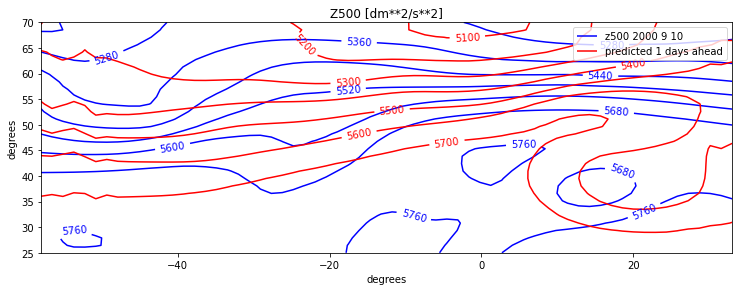

In [29]:
# Give here a date
date = "2000 9 10"

# load model
forecast = load_model("data/forecast.h5")
days_ahead = 1

# load data
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")
dates = np.load("data/dates.npy")
date_index = np.where(dates == date)[0][0]
x_in = data[date_index-days_ahead-sequence_length:date_index-days_ahead,...]

# predict
x_in = x_in[np.newaxis,...]
x_forecast = forecast.predict(x_in)
x_forecast = x_forecast.reshape(data.shape[1],data.shape[2])

# plot
isoplot(data[date_index,:,:,0],x_forecast,"z500 "+date,"predicted "+str(days_ahead)+ " days ahead",zone,scale[1]*10,"Z500 [dm**2/s**2]")